# Polynomial regression 

The example belows uses a temperature-energy dataset in order to illustrate how to perform a non linear regression.

Workflow:
1. Preparation
    - Extract the dataset from the _power_demand_vs_temperature.csv_ 
    - Explore the dataset and check for missing values
    - Plot the distribution
    - Divide the dataset into train and test 
    - Create an evaluation function
2. First experiment
    - Create a linear model 
    - Train the model on X_train and y_train
    - Evaluate the model on X_test and y_test
    - Visualize the prediction of the model
3. Second experiment
    - Create a polynomial regression model with degree 2
    - Train the model on X_train and y_train
    - Evaluate the model on X_test and y_test
    - Visualize the prediction of the model
4. Third experiment
    - repeat the steps done in the second experiment but with degree 3
5. Third experiment
    - repeat the steps done in the second experiment but with degree 4
6. Compare the evaluation of each model


In [ ]:
# Code source: Filippo Orazi 
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

random_state = 42 # this will be used to guarantee the repeatability of the experiment

## Dataset preparation

### Load the dataset from a `.csv` file
This cell allows full compatibility between execution in Google Colab and in local


In [ ]:
try:
  from google.colab import files
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
    uploaded = files.upload()


Saving power_demand_vs_temperature.csv to power_demand_vs_temperature.csv


The file must be available in the same directory, or uploaded in the Colab environment in the execution of the previous cell


Set the date column as index

In [ ]:
data_fn = 'power_demand_vs_temperature.csv'
df = pd.read_csv(data_fn, index_col=0)
df.head()

,demand,temp
date,,
2015-01-01,1.736065,1.7
2015-01-02,1.831672,2.2
2015-01-03,1.714934,14.4
2015-01-04,1.628577,15.6
2015-01-05,2.045394,0.0


### Explore the dataset and check for missing values


In [ ]:
df.describe()

,demand,temp
count,1096.000000,1096.000000
mean,1.831796,16.927737
std,0.329434,10.791581
min,1.316033,-15.000000
25%,1.581654,8.900000
50%,1.731479,18.900000
75%,2.024869,26.100000
max,2.804025,33.900000


In [ ]:
print('The dataframe has', df.count()[0] - df.dropna().count()[0], 'invalid rows')

The dataframe has 0 invalid rows


### Create X and y 

In [ ]:
target_name = 'demand'
X = df['temp']
y = df[target_name]

# We're trying to infer the value of the power demand based on the temperature

X = X.values.reshape(-1, 1)

print('X has shape', X.shape)
print('y has shape', y.shape)

X has shape (1096, 1)
y has shape (1096,)


### Plot the distribution



Text(0, 0.5, 'Power Demand')

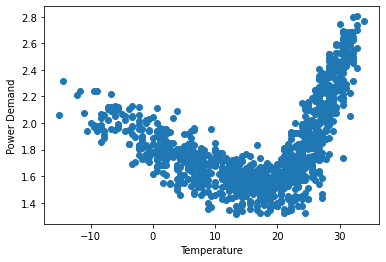

In [ ]:
plt.scatter(X, y)
plt.xlabel('Temperature')
plt.ylabel('Power Demand')

### Divide the dataset in train and test splits

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=random_state)
print('The train set has', len(ytrain), 'samples\nThe test set has', len(ytest), 'samples')

The train set has 822 samples
The test set has 274 samples


### Create an evaluation function to compute, print and return the metrics: rmse r2 f-statistic and p-value

In [ ]:
# Computation of F-statistic and p-value for the regression
# http://facweb.cs.depaul.edu/sjost/csc423/documents/f-test-reg.htm

# Sources: 
# - https://stackoverflow.com/a/57239611
# - https://stats.stackexchange.com/questions/56881/whats-the-relationship-between-r2-and-f-test
# - https://www.statology.org/f-test-python/

# First link contains additional quality measures

import sklearn.metrics as metrics

def regression_results(x_test, y_true, y_pred):

    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred) 
    mse = metrics.mean_squared_error(y_true, y_pred) 
    # mean_squared_log_error = metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    dfn = x_test.shape[1]       # DOF Numerator = K;           where: K = num of predictors (i.e., num of independent variables)
    dfd = len(y_true) - (dfn+1) # DOF Denominator = N - (K+1); where: N = num of samples; K = num of predictors
    
    #fstat = np.var(x_test, ddof=1)/np.var(y_true, ddof=1)
    fstat = (r2/(1-r2))*(dfd/dfn)
    p_val = 1 - scipy.stats.f.cdf(fstat, dfn, dfd) # 1 - sm.F(K - 1, N - K).cdf(fstat)

    rmse = np.sqrt(mse)

    print('RMSE: ', round(rmse,4))
    print('r2: ', round(r2,4))
    print('F-statistic: ', round(fstat, 4))
    print('p-value: ', p_val)#round(p_val,4)) # avoid rounding very small p-values to 0.0

    return rmse, r2, fstat, p_val


## First experiment
Create a linear model 

Train the model on X_train and y_train 

Evaluate the model on X_test and y_test


In [ ]:
scores = []

model = linear_model.LinearRegression()
model = model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

rmse, r2, fstat, p_val = regression_results(Xtest, ytest, ypred)
scores.append([rmse, r2, fstat, p_val])

RMSE:  0.3158
r2:  0.165
F-statistic:  53.7374
p-value:  2.6256774532384952e-12


#### Visualize the prediction of the model 

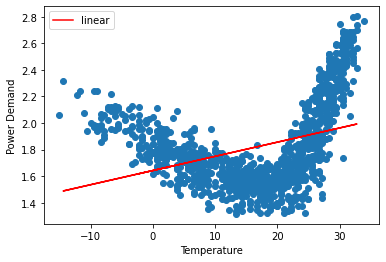

In [ ]:
plt.scatter(x=X, y=y)
plt.plot(Xtest, ypred, c='r', label='linear')
plt.legend(loc="upper left")
plt.xlabel('Temperature')
plt.ylabel('Power Demand')
plt.show()


## Second experiment - Polynomial regression
We can clearly see that the linear regression model cannot really approximate the data distribution.

We can now try with a non linear regression model:
1. Use the sklearn fucntion _PolynomialFeature_ to create a new array of features. Set _degree=2_ and _include_bias=False_
2. Train a Linear regression model with the new features
3. Evaluate the model 
4. Visualize the predicted values of the model

#### Polynomial degree = 2

First we obtain the array containing the polynomial features, hence, knowing $x_i$ for each sample $i$, we compute $$ \beta_0 + \beta_1x_i + \beta_2x_i^2 + \ldots \beta_dx_i^d$$
With d being the degree of the polynomial (in this case, 2) and $\beta_j$ the j-th coefficient (handled automatically?)

Then we train the linear model on the polynomial features, specifying the expected output (ytrain)

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False) #LinearRegression model already handles the bias (y intercept)
# computes the features (values of the independent variables) for each degree of the polynomial (in this case up to 2)
poly_features = poly.fit_transform(Xtrain)
# now we fit the linear reg model on the polynomial features, the sum of which, for each i, must match the respective y value
model.fit(poly_features, ytrain)

LinearRegression()

In [ ]:
# To predict using polynomial regression we have to first compute the polynomial features of the test set
poly_features_test = poly.fit_transform(Xtest)
ypred = model.predict(poly_features_test)

# Important: the f-statistic and p-value have to be computed based on the polynomial features array, not the linear one
rmse, r2, fstat, p_val = regression_results(poly_features_test, ytest, ypred)
scores.append([rmse, r2, fstat, p_val])

RMSE:  0.1777
r2:  0.7356
F-statistic:  377.007
p-value:  1.1102230246251565e-16


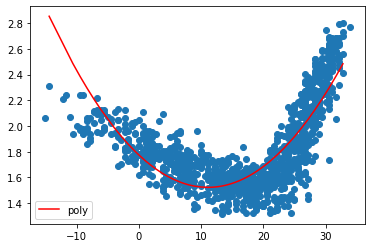

In [ ]:
Xtestinds = Xtest.flatten().argsort()
sorted_Xtest = Xtest[Xtestinds]
sorted_ypred = ypred[Xtestinds]

plt.scatter(x=X, y=y)
plt.plot(sorted_Xtest, sorted_ypred, c='r', label='poly')
plt.legend(loc="lower left")
plt.show()

## Third experiment

#### Polynomial degree = 3

In [ ]:
poly = PolynomialFeatures(degree=3, include_bias=False) #LinearRegression model already handles the bias (y intercept)
# computes the features (values of the independent variables) for each degree of the polynomial (in this case up to 2)
poly_features = poly.fit_transform(Xtrain)
# now we fit the linear reg model on the polynomial features, the sum of which, for each i, must match the respective y value
model.fit(poly_features, ytrain)

LinearRegression()

In [ ]:
# To predict using polynomial regression we have to first compute the polynomial features of the test set
poly_features_test = poly.fit_transform(Xtest)
ypred = model.predict(poly_features_test)

# Important: the f-statistic and p-value have to be computed based on the polynomial features array, not the linear one
rmse, r2, fstat, p_val = regression_results(poly_features_test, ytest, ypred)
scores.append([rmse, r2, fstat, p_val])

RMSE:  0.1414
r2:  0.8326
F-statistic:  447.5508
p-value:  1.1102230246251565e-16


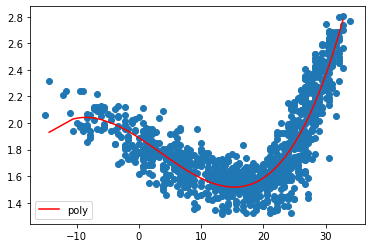

In [ ]:
Xtestinds = Xtest.flatten().argsort()
sorted_Xtest = Xtest[Xtestinds]
sorted_ypred = ypred[Xtestinds]

plt.scatter(x=X, y=y)
plt.plot(sorted_Xtest, sorted_ypred, c='r', label='poly')
plt.legend(loc="lower left")
plt.show()

## Fourth experiment
### Polynomial degree = 4

In [ ]:
poly = PolynomialFeatures(degree=4, include_bias=False) #LinearRegression model already handles the bias (y intercept)
# computes the features (values of the independent variables) for each degree of the polynomial (in this case up to 2)
poly_features = poly.fit_transform(Xtrain)
# now we fit the linear reg model on the polynomial features, the sum of which, for each i, must match the respective y value
model.fit(poly_features, ytrain)

LinearRegression()

In [ ]:
# To predict using polynomial regression we have to first compute the polynomial features of the test set
poly_features_test = poly.fit_transform(Xtest)
ypred = model.predict(poly_features_test)

# Important: the f-statistic and p-value have to be computed based on the polynomial features array, not the linear one
rmse, r2, fstat, p_val = regression_results(poly_features_test, ytest, ypred)
scores.append([rmse, r2, fstat, p_val])

RMSE:  0.1403
r2:  0.8351
F-statistic:  340.6006
p-value:  1.1102230246251565e-16


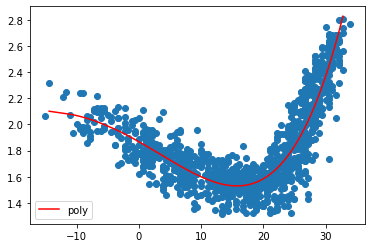

In [ ]:
Xtestinds = Xtest.flatten().argsort()
sorted_Xtest = Xtest[Xtestinds]
sorted_ypred = ypred[Xtestinds]

plt.scatter(x=X, y=y)
plt.plot(sorted_Xtest, sorted_ypred, c='r', label='poly')
plt.legend(loc="lower left")
plt.show()

## Compare the performance of the four models

In [ ]:
comp = pd.DataFrame(np.transpose(scores), columns=['linear', 'polynomial d=2', 'polynomial d=3', 'polynomial d=4'], index=['rmse','r2','f-stat','p-value'])

comp.head()

[[0.31582119796104285, 0.16497160632995378, 53.73742648980904, 2.6256774532384952e-12], [0.177709400808168, 0.7356133663568161, 377.0069983033663, 1.1102230246251565e-16], [0.14141717682425192, 0.83257395588548, 447.55077638004565, 1.1102230246251565e-16], [0.14034154337480137, 0.8351111889083296, 340.60059674311174, 1.1102230246251565e-16]]
[[3.15821198e-01 1.77709401e-01 1.41417177e-01 1.40341543e-01]
 [1.64971606e-01 7.35613366e-01 8.32573956e-01 8.35111189e-01]
 [5.37374265e+01 3.77006998e+02 4.47550776e+02 3.40600597e+02]
 [2.62567745e-12 1.11022302e-16 1.11022302e-16 1.11022302e-16]]


,linear,polynomial d=2,polynomial d=3,polynomial d=4
rmse,3.158212e-01,1.777094e-01,1.414172e-01,1.403415e-01
r2,1.649716e-01,7.356134e-01,8.325740e-01,8.351112e-01
f-stat,5.373743e+01,3.770070e+02,4.475508e+02,3.406006e+02
p-value,2.625677e-12,1.110223e-16,1.110223e-16,1.110223e-16
